In [ ]:
pip install aif360 pandas matplotlib seaborn scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 3.6 MB/s eta 0:00:00


Original DataFrame shape: (7214, 53)
StandardDataset features shape: (7214, 456)

Basic Info:
               instance weights features                               \
                                                                        
                                     age juv_fel_count juv_misd_count   
instance names                                                          
0                           1.0     69.0           0.0            0.0   
1                           1.0     34.0           0.0            0.0   
2                           1.0     24.0           0.0            0.0   
3                           1.0     23.0           0.0            1.0   
4                           1.0     43.0           0.0            0.0   
...                         ...      ...           ...            ...   
7209                        1.0     23.0           0.0            0.0   
7210                        1.0     23.0           0.0            0.0   
7211                        1.

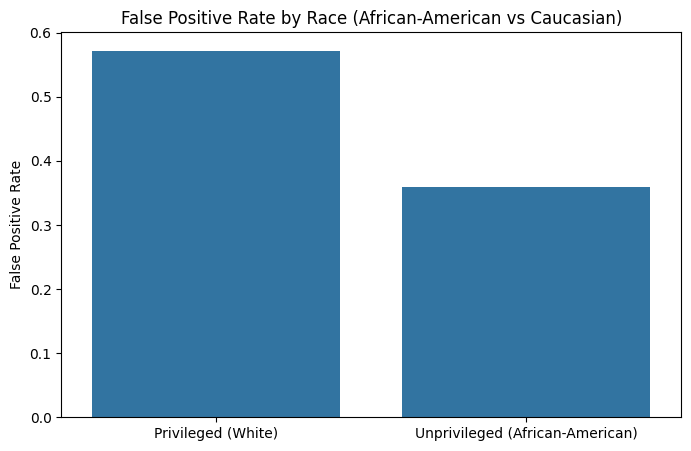

In [39]:
import pandas as pd
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from aif360.metrics import ClassificationMetric
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset from CSV
filepath = 'compas-scores-two-years.csv'
df = pd.read_csv(filepath)

# Print the shape of the original DataFrame
print("Original DataFrame shape:", df.shape)

# --- Data Preprocessing ---
# Select a subset of relevant columns
selected_columns = ['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count',
                    'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_desc',
                    'days_b_screening_arrest', 'two_year_recid']

df_subset = df[selected_columns].copy()

# Handle missing values in 'days_b_screening_arrest' - fill with 0 or a more appropriate value
# Let's fill with 0 for simplicity, but consider a more robust imputation strategy if needed.
df_subset['days_b_screening_arrest'] = df_subset['days_b_screening_arrest'].fillna(0)

# One-hot encode categorical features, including 'race'
categorical_cols = ['sex', 'age_cat', 'race', 'c_charge_degree', 'c_charge_desc']
df_processed = pd.get_dummies(df_subset, columns=categorical_cols, drop_first=False) # Keep all dummy columns for now

# Define the label and protected attribute names in the processed DataFrame
label_name = 'two_year_recid'
# Protected attribute names are now the one-hot encoded columns for 'race'
protected_attribute_names = [col for col in df_processed.columns if col.startswith('race_')]

# Define favorable class for the label
favorable_classes = [0] # Assuming 0 is favorable (no recidivism)

# Define privileged classes for the protected attribute based on one-hot encoding
# 'Caucasian' is the privileged class, so the privileged class corresponds to
# having a value of 1 in the 'race_Caucasian' column.
# When using a pre-encoded DataFrame, privileged_classes should match the numerical value (1)
privileged_classes = [[1]]


# Convert preprocessed pandas DataFrame to aif360 StandardDataset
# No need to specify categorical_features or na_values now as data is preprocessed
dataset = StandardDataset(df_processed,
                          label_name=label_name,
                          protected_attribute_names=protected_attribute_names,
                          favorable_classes=favorable_classes,
                          privileged_classes=privileged_classes)


# Print the shape of the StandardDataset features array
print("StandardDataset features shape:", dataset.features.shape)


# Show basic info
print("\nBasic Info:")
print(dataset)

# Define privileged and unprivileged groups for fairness metrics
# These need to be dictionaries matching the dataset's internal representation
# based on the one-hot encoded protected attributes.
# Privileged group is where 'race_Caucasian' is 1
privileged_groups = [{'race_Caucasian': 1}]
# Unprivileged group(s) can be defined for other race categories.
# Let's define African-American as the primary unprivileged group for this example.
unprivileged_groups = [{'race_African-American': 1}]


# Compute basic fairness metrics
metric = BinaryLabelDatasetMetric(dataset,
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)

print("\nStatistical Parity Difference:", metric.statistical_parity_difference())
print("Disparate Impact:", metric.disparate_impact())

# Split data
dataset_train, dataset_test = dataset.split([0.7], shuffle=True)

# Train model
model = LogisticRegression(solver='liblinear', max_iter=1000)
# Check shape of training data before fitting
print("Training dataset features shape:", dataset_train.features.shape)
mdl = model.fit(dataset_train.features, dataset_train.labels.ravel())

# Predict
preds = mdl.predict(dataset_test.features)

# Convert to aif360 classification metric
# Create a new dataset with predictions as labels
dataset_pred = dataset_test.copy()
dataset_pred.labels = preds.reshape(-1, 1) # Reshape predictions to match dataset labels shape

# Print type of dataset_pred before passing to ClassificationMetric
print("\nType of dataset_pred before ClassificationMetric:", type(dataset_pred))

classified_metric = ClassificationMetric(dataset_test, dataset_pred,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)


print("\nFalse Positive Rate (White):", classified_metric.false_positive_rate(privileged=True))
print("False Positive Rate (Non-white):", classified_metric.false_positive_rate(privileged=False))
print("FPR Difference:", classified_metric.false_positive_rate_difference())

# Visualization
fpr_diff = {
    "Privileged (White)": classified_metric.false_positive_rate(privileged=True),
    "Unprivileged (African-American)": classified_metric.false_positive_rate(privileged=False)
}

plt.figure(figsize=(8,5))
sns.barplot(x=list(fpr_diff.keys()), y=list(fpr_diff.values()))
plt.ylabel('False Positive Rate')
plt.title('False Positive Rate by Race (African-American vs Caucasian)')
plt.show()